In [ ]:
!rm -rf gx
!pip install pandas
!pip install great_expectations -q

### **Great Expectation**

Great Expectations (GX) is an open-source tool for data validation and profiling
It is a framework for describing data using expressive tests and then validating that the data meets test criteria. GX Core is a Python library that provides a programmatic interface to building and running data validation workflows using GX.

GX Core is versatile and supports a variety of workflows. It can be used for interactive, exploratory data validation as well as data validation within production deployments.

### **The pattern of a GX workflow**

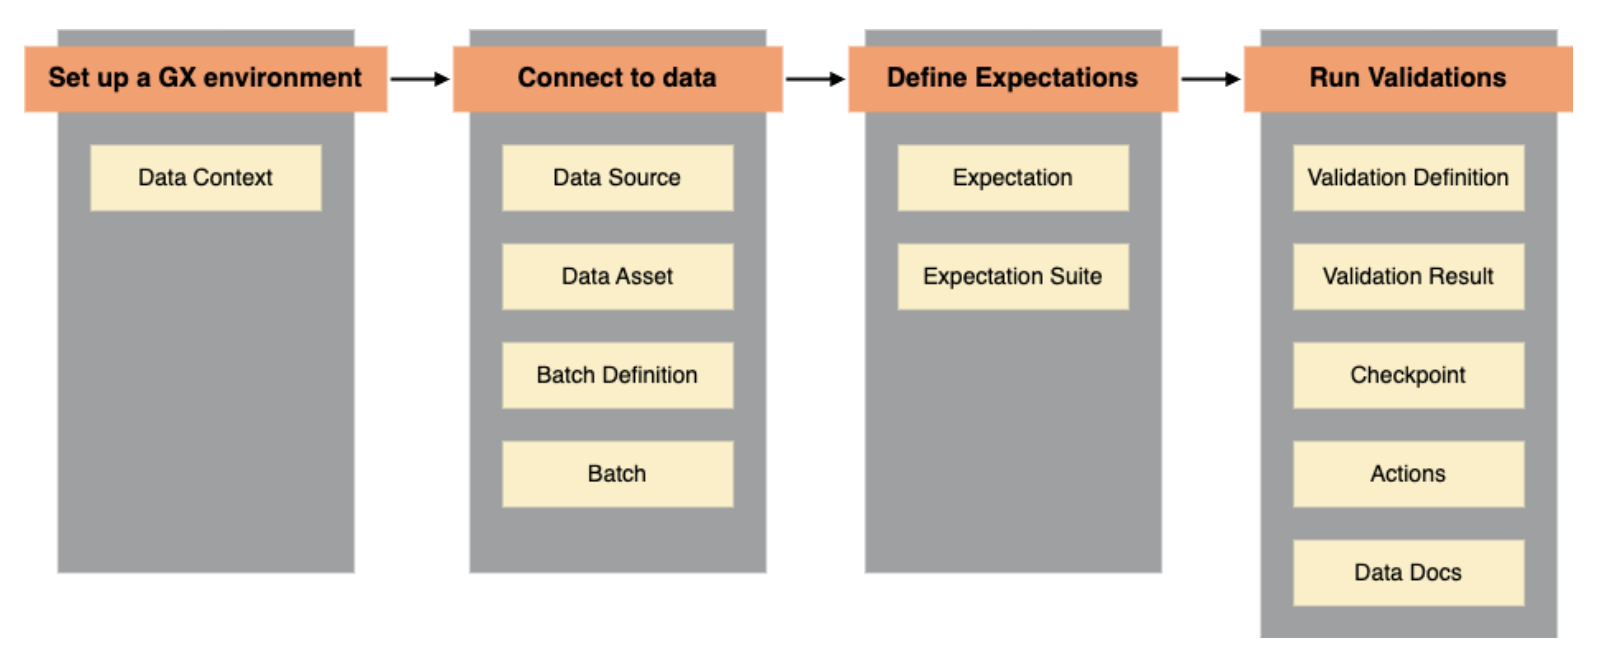

In [ ]:
import great_expectations as gx
from great_expectations.data_context.types.base import DataContextConfig
from great_expectations.checkpoint import CheckpointResult

import pandas as pd

ModuleNotFoundError: No module named 'great_expectations'

In [ ]:
from sklearn.datasets import fetch_openml

# Fetch the dataset
adult_census = fetch_openml("adult", version=2, as_frame=True)

# Convert to a DataFrame
df = adult_census.frame

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:110: UserWarning: A network error occurred while downloading https://api.openml.org/api/v1/json/data/list/data_name/adult/limit/2/data_version/2. Retrying...
  warn(


URLError: <urlopen error [Errno 110] Connection timed out>

In [ ]:
df.head(4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K


A **DataContext** is a core concept in Great Expectations, acting as the central configuration, orchestration, and execution layer. It encapsulates the configuration settings, data sources, validation rules (expectations), and validation results. Essentially, it is the entry point to interact with Great Expectations in a structured and organized way.

### **Key Responsibilities of a DataContext**:
#### **Configuration Management**:

Holds settings for data sources, validation stores, and how data is organized.
Configuration is typically stored in a great_expectations.yml file.
#### **Expectation Suite Management**:

Organizes, creates, and modifies Expectation Suites, which define the rules for data validation.
#### **Validation Execution**:

Executes data validations using Expectations and Checkpoints.
Stores results of validations for further analysis or reporting.
#### **Data Documentation**:

Generates Data Docs, a human-readable validation report.
Provides a web-based view to see validation results and expectations.
#### **Batch and Validator Management**:

Interfaces with your data via Batches (subsets of data to validate).
Manages Validators to apply Expectations on data.

#### **Types of DataContext**

**AbstractDataContext** : *Base class for all Datacontext*

**CloudDataContext**: *Subclass of AbstractDataContext that contains functionality necessary to work in a GX Cloud-backed environment.*

**EphemeralDataContext**: *Subclass of AbstractDataContext that uses runtime values to generate a temporary or in-memory DataContext.*

**FileDataContext**: *Contains functionality necessary to work in a filesystem-backed environment.*



In [ ]:
#1. Create a Data Context
context = gx.get_context(mode="file")

print(type(context).__name__)

FileDataContext


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[link text](https://)#### **Connecting to Data Source**
##### SQL
GX supports the following SQL dialects:

    - PostgreSQL
    - SQLite
    - Snowflake
    - Databricks SQL
    - BigQuery SQL
##### File System
Filesystem data consists of data stored in file formats such as .csv or .parquet, and located in an environment with a folder hierarchy such as Amazon S3, Azure Blob Storage, Google Cloud Storage, or local and networked filesystems.
##### DataFrame
A dataframe is a set of data that resides in-memory and is represented in your code by a variable to which it is assigned.

In [ ]:
# 2. Set up a Datasource (CSV file example)
data_source_name = "my_data_source"
data_source = context.data_sources.add_pandas(name=data_source_name)


# A dataframe Data Asset is used to group your Validation Results.
# You can think it like a table of a database.
data_asset_name = "my_dataframe_data_asset"
data_asset = data_source.add_dataframe_asset(name=data_asset_name)

In [ ]:
# 3. Create a Batch from the DataFrame

# Batch Definitions for dataframe Data Assets don't work to subdivide
# the data returned for validation. Instead, they serve as an additional layer of
# organization and allow you to further group your Validation Results.

batch_definition = data_asset.add_batch_definition_whole_dataframe("batch definition")
batch_parameters = {"dataframe": df}
batch = batch_definition.get_batch(batch_parameters)
print(batch.head(3))

Calculating Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

   age  workclass  fnlwgt   education  education-num      marital-status  \
0   25    Private  226802        11th              7       Never-married   
1   38    Private   89814     HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951  Assoc-acdm             12  Married-civ-spouse   

          occupation relationship   race   sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black  Male             0             0   
1    Farming-fishing      Husband  White  Male             0             0   
2    Protective-serv      Husband  White  Male             0             0   

   hours-per-week native-country  class  
0              40  United-States  <=50K  
1              50  United-States  <=50K  
2              40  United-States   >50K  


In [ ]:
# 4. Create an Expectation.
#Expectations are a fundamental component of GX. They allow you to explicitly define the state to which your data should conform.
# https://greatexpectations.io/expectations/
expectation = gx.expectations.ExpectColumnValuesToBeBetween(
    column="education-num", min_value=2, max_value=3
)

#Run and get the results!
validation_result = batch.validate(expectation)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Calculating Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
print(validation_result)

{
  "success": false,
  "expectation_config": {
    "type": "expect_column_values_to_be_between",
    "kwargs": {
      "batch_id": "my_data_source-my_dataframe_data_asset",
      "column": "education-num",
      "min_value": 2.0,
      "max_value": 3.0
    },
    "meta": {}
  },
  "result": {
    "element_count": 48842,
    "unexpected_count": 48086,
    "unexpected_percent": 98.45215183653413,
    "partial_unexpected_list": [
      7,
      9,
      12,
      10,
      10,
      6,
      9,
      15,
      10,
      4,
      9,
      13,
      9,
      9,
      9,
      14,
      10,
      9,
      9,
      16
    ],
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_percent_total": 98.45215183653413,
    "unexpected_percent_nonmissing": 98.45215183653413,
    "partial_unexpected_counts": [
      {
        "value": 9,
        "count": 8
      },
      {
        "value": 10,
        "count": 4
      },
      {
        "value": 4,
        "count": 1
      },
      {
  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
expectation_2 = gx.expectations.ExpectColumnValuesToBeInSet(column="relationship",
                                                            value_set=["One-child",
                                                                       "Husband",
                                                                       "Not-in-family",
                                                                       "Unmarried",
                                                                       "Wife",
                                                                       "Own-child",
                                                                       "Other-relative"
                                                                       ])

#Run and get the results!
validation_result = batch.validate(expectation_2)

Calculating Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

#### Organise expectation into Suite

An Expectation Suite contains a group of Expectations that describe the same set of data. Combining all the Expectations that you apply to a given set of data into an Expectation Suite allows you to evaluate them as a group, rather than individually.

In [ ]:
suite_name = "my_expectation_suite"
suite = gx.ExpectationSuite(name=suite_name)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
suite = context.suites.add(suite)

In [ ]:
suite.add_expectation(expectation)
suite.add_expectation(expectation_2)

ExpectColumnValuesToBeInSet(id='cf49bec0-0dc9-40ff-8653-518495b31da6', meta=None, notes=None, result_format=<ResultFormat.BASIC: 'BASIC'>, description=None, catch_exceptions=True, rendered_content=None, windows=None, batch_id=None, column='relationship', mostly=1, row_condition=None, condition_parser=None, value_set=['One-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Own-child', 'Other-relative'])

#### Validation Definition

A Validation Definition is a fixed reference that links a Batch of data to an Expectation Suite.

In [ ]:
definition_name = "my_validation_definition"
validation_definition = gx.ValidationDefinition(
    data=batch_definition, suite=suite, name=definition_name
)

In [ ]:
# Save the validation defintion to your context
validation_definition = context.validation_definitions.add(validation_definition)

Run a Validation Definition

In [ ]:
validation_definition_name = "my_validation_definition"
validation_definition = context.validation_definitions.get(validation_definition_name)

validation_results = validation_definition.run(batch_parameters=batch_parameters)
print(validation_results)

Calculating Metrics:   0%|          | 0/20 [00:00<?, ?it/s]

{
  "success": false,
  "results": [
    {
      "success": false,
      "expectation_config": {
        "type": "expect_column_values_to_be_between",
        "kwargs": {
          "batch_id": "my_data_source-my_dataframe_data_asset",
          "column": "education-num",
          "min_value": 2.0,
          "max_value": 3.0
        },
        "meta": {},
        "id": "c7a22b29-1187-4a8b-bc24-465444ed2427"
      },
      "result": {
        "element_count": 48842,
        "unexpected_count": 48086,
        "unexpected_percent": 98.45215183653413,
        "partial_unexpected_list": [
          7,
          9,
          12,
          10,
          10,
          6,
          9,
          15,
          10,
          4,
          9,
          13,
          9,
          9,
          9,
          14,
          10,
          9,
          9,
          16
        ],
        "missing_count": 0,
        "missing_percent": 0.0,
        "unexpected_percent_total": 98.45215183653413,
        "unexpe

#### Trigger Action
##### Create a Checkpoint with Actions
A Checkpoint is the primary means for validating data in a production deployment of Great Expectations.

In [ ]:
from great_expectations.checkpoint import (
    SlackNotificationAction,
    UpdateDataDocsAction,
    EmailAction
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
context = gx.get_context()

In [ ]:
validation_definitions = [
    context.validation_definitions.get("my_validation_definition")
]

In [ ]:
email_action =[EmailAction(
    name="send_email_on_failure",
    smtp_address='smtp.gmail.com',
    smtp_port=587,
    receiver_emails="singh.mayank@iitgn.ac.in",
    sender_login="24210086@iitgn.ac.in",
    #sender_password="xmfo fxlf slox pumb",
    sender_password="viot zigw isup rnko",
    use_tls=True,
    notify_on="all",
)]

In [ ]:
checkpoint_name = "my_checkpoint"
checkpoint = gx.Checkpoint(
    name=checkpoint_name,
    validation_definitions=validation_definitions,
    actions=email_action,
    result_format={"result_format": "COMPLETE"},
)

# Save the Checkpoint to the Data Context
context.checkpoints.add(checkpoint)

# Retrieve the Checkpoint later
checkpoint_name = "my_checkpoint"
checkpoint = context.checkpoints.get(checkpoint_name)

NameError: name 'validation_definitions' is not defined

In [ ]:
validation_results = checkpoint.run(
    batch_parameters=batch_parameters, expectation_parameters=suite
)

NameError: name 'checkpoint' is not defined